# Lab 5: Spam Detection

**Deadline**: Thursday, July 9, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Baiwu (Chris) Zhang  

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1SVGG4YTFuKdoWjiKKvPmwZoesE30-8Rt#scrollTo=HgfNOUaPa9z8

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt # for plotting

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
#Mount the Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cnt = 0
for line in open('/content/drive/My Drive/Colab Notebooks/Lab5/SMSSpamCollection'):
    print(line)
    a = line.split("\t")
    print("Label is: {} | SMS is: {}".format(a[0],a[1]))
    cnt+=1
    if cnt == 10:
        break

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Label is: ham | SMS is: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

ham	Ok lar... Joking wif u oni...

Label is: ham | SMS is: Ok lar... Joking wif u oni...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

Label is: spam | SMS is: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

ham	U dun say so early hor... U c already then say...

Label is: ham | SMS is: U dun say so early hor... U c already then say...

ham	Nah I don't think he goes to usf, he lives around here though

Label is: ham | SMS is: Nah I don't think he goes to usf, he lives around here though

spam	FreeMsg Hey there darli

Spam messages are labelled spam while non-spam is labelled ham. 

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
cnt = 0
for line in open('/content/drive/My Drive/Colab Notebooks/Lab5/SMSSpamCollection'):
    cnt+=1
print(cnt)

5574


Therefore, there are 5574 spam messages in the doc. 

### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

Advantages include (1) can identify common typos/acronyms and label them with a certain meaning, (2) Spam messages often have codes rather than words, which can be identified as a sequence of characters, if we were to model with words, the codes would be labelled as unknown entities and this wouldn't help with our detection software as anything that isn't in model's vocab is labelled as unknown entities. 

Disadvantages include (1) more computation (2) takes longer to go through each line.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
import torchtext

text_field = torchtext.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset("/content/drive/My Drive/Colab Notebooks/Lab5/SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)


dataset[0].sms
dataset[0].label
train, valid, test = dataset.split(split_ratio=[0.6,0.2,0.2], stratified=False, strata_field='label', random_state=None)

In [ ]:
cnt = 0
for line in dataset[0].sms:
  print(line)
  cnt+=1
  if cnt == 10:
    break

G
o
 
u
n
t
i
l
 
j


In [ ]:
|ct = 0
for line in train:
    ct +=1
print(ct)

cv = 0
for line in valid:
    cv +=1
print(cv)

cte = 0
for line in test:
    cte +=1
print(cte)

3343
1115
1114


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

The algorithm wants to maximize accuracy and reduce error. An imbalanced training set may skew the accuracy of the model by making it favor the majority class (non-spam) and thus, may fail to perform accurately for the minority class (spam messages) by not paying enough attention to them. A balanced training set removes this risk and ensures both spam and non-spam messages are considered at an equal magnitude. 

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)
#text_field.vocab.stoi
#text_field.vocab.itos

text_field.vocab.stoi  -  used to find the number the tokens have been assigned 


text_field.vocab.itos  -  used to find the token the number is assigned to

**Example**
```
example input: print(EN_TEXT.vocab.stoi['the'])
example_output: 11
example input: print(EN_TEXT.vocab.itos[11])
example_output: 'the'
```



### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [ ]:
# <pad> is a token for padding (to make sequences the same length for better input to the neural network)
# <unk> is a token that does not exist in our list of unique tokens. 

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

**Found on Piazza: **
Given some batch in train_iter, batch.sms contains two tensors:

batch.sms[0] is a tensor representing a sequence of characters, where the characters are represented by the enumeration that you can find via text_field.vocab.stoi. These sequences are all padded to the max length of that batch.

batch.sms[1] is a tensor that represents the "raw" length of the sequences (without padding to the max sequence length per batch)

In [ ]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
for batch in train_iter:
    break

print("Length of batch: {}".format(len(batch)))
print("Raw lengths:")
print(batch.sms[1])
print("Padded lengths:")
print(batch.sms[0])
#print(batch.label)

Length of batch: 32
Raw lengths:
tensor([122, 122, 122, 122, 122, 122, 122, 121, 121, 121, 121, 121, 121, 121,
        121, 121, 121, 121, 121, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120])
Padded lengths:
tensor([[57,  4,  8,  ..., 59, 20, 29],
        [55,  9, 11,  ...,  9,  5, 16],
        [35, 29, 16,  ..., 31,  3, 16],
        ...,
        [20,  6,  5,  ..., 16,  1,  1],
        [ 5,  3, 11,  ..., 46,  1,  1],
        [ 5,  3, 11,  ..., 46,  1,  1]])


In [ ]:
text_field.vocab.itos[1]

## <pad> is text_field.vocab.itos[1], so in the tensor it's the 1's

'<pad>'

Looking at 10 batches, I found the max length to be the largest number in 
`batch.sms[1] ` while the amount of padding used for each sms message line is dependent on the difference between the max value and each line's length. For some batches, the lengths are all the same with no padding required, for others, there's usually only 1 - 4 paddings added at the very end. 

## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
##### Using torch.cat CODE #############################################################

# RNN Architecture
class SpamRNN(nn.Module):

  def __init__(self, input_size, hidden_size, num_classes):
    super(SpamRNN, self).__init__()
    self.ident = torch.eye(input_size) 
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    self.rnn = nn.RNN(input_size, hidden_size, num_classes, batch_first=True)
    self.fc = nn.Linear(40, num_classes)

  def forward(self, x):
    # Look up the embedding
    x = self.ident[x]    ## This is your one hot encode? So it's passing in the character as x
    # Set an initial hidden state
    h0 = torch.zeros(self.num_classes, x.size(0), self.hidden_size)
    # Forward propagate the RNN
    out, _ = self.rnn(x, h0)
    # Pass the output of the last time step to the classifier

    # Hyperparameter 1
    #output = self.fc(torch.max(out, dim=1)[0])

    # Hyperparameter 2
    out = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)
    output = self.fc(out)
    return output

###############################################################################

In [ ]:
##### Using only torch.max CODE #############################################################

# RNN Architecture
class SpamRNN(nn.Module):

  def __init__(self, input_size, hidden_size, num_classes):
    super(SpamRNN, self).__init__()
    self.ident = torch.eye(input_size) 
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    self.rnn = nn.RNN(input_size, hidden_size, num_classes, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    # Look up the embedding
    x = self.ident[x]    ## This is your one hot encode? So it's passing in the character as x
    # Set an initial hidden state
    h0 = torch.zeros(self.num_classes, x.size(0), self.hidden_size)
    # Forward propagate the RNN
    out, _ = self.rnn(x, h0)
    # Pass the output of the last time step to the classifier

    # Hyperparameter 1
    output = self.fc(torch.max(out, dim=1)[0])

    # Hyperparameter 2
    #out = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)
    #output = self.fc(out)
    return output

###############################################################################

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
##### SAMPLE CODE #############################################################
def get_accuracy(model, data, batch_size = 32):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    data_iter = torchtext.data.BucketIterator(data,
                              batch_size=batch_size,
                              sort_key=lambda x: len(x.sms), # to minimize padding
                              sort_within_batch=True, # sort within each batch
                              repeat=False) # repeat the iterator for many epochs
    correct, total = 0, 0
    for batch in data_iter:
      output = model(batch.sms[0])
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(batch.label.view_as(pred)).sum().item()
      total += batch.sms[1].shape[0]
    return correct / total

###############################################################################

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [ ]:
############### INCOMPLETE SAMPLE CODE #########################################

def train_rnn_network(model, train, valid, batch_size=32, num_epochs=30, learning_rate=1e-5):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Lists for Plotting
  iters, losses, train_acc, val_acc = [], [], [], []


  train_loader = torchtext.data.BucketIterator(train,
                          batch_size=batch_size,
                          sort_key=lambda x: len(x.sms), # to minimize padding
                          sort_within_batch=True, # sort within each batch
                          repeat=False) # repeat the iterator for many epochs

  valid_loader = torchtext.data.BucketIterator(valid,
                          batch_size=batch_size,
                          sort_key=lambda x: len(x.sms), # to minimize padding
                          sort_within_batch=True, # sort within each batch
                          repeat=False) # repeat the iterator for many epochs

  # training
  print ("Training Started...")
  n = 0 # the number of iterations
  for epoch in range(num_epochs):
    for batch in train_loader:
      optimizer.zero_grad()
      pred = model(batch.sms[0])
      loss = criterion(pred, batch.label)
      loss.backward()
      optimizer.step()
      n+=1

    # track accuracy
    iters.append(n)
    losses.append(float(loss)/batch_size)                 # compute average loss
    train_acc.append(get_accuracy(model, train))   # compute training accuracy
    val_acc.append(get_accuracy(model, valid))       # compute valiation accuracy
    print(epoch, train_acc[-1], val_acc[-1])

    #print("epoch: ", epoch, end = " ")
    #print("train acc: ", get_accuracy(model, train), end = " ")
    #print("val acc: ", get_accuracy(model, valid))

  # plotting
  plt.title("Training Curve")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(iters, train_acc, label="Train")
  plt.plot(iters, val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))

  return train_acc, val_acc


### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [ ]:
## The first hyperparameter I tuned is to concatenate the max-pooling and average-pooling of the RNN outputs rather than just use the max-pooling (like in the sample code). 
model_4 = SpamRNN(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
train_rnn_network(model_4, train, valid, batch_size=32, num_epochs=20, learning_rate=1e-4)

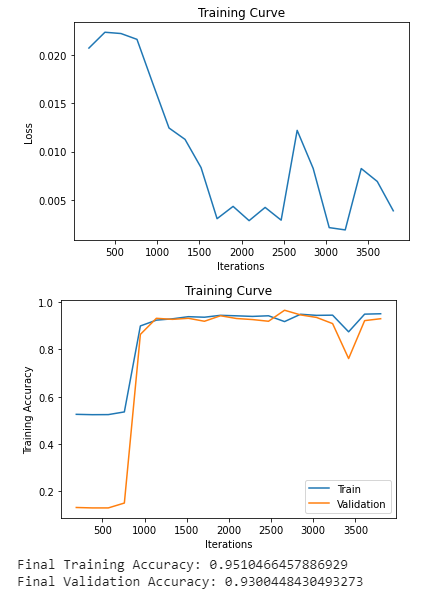

In [ ]:
# I will increase the learning rate seeing the accuracies level off at around 90 percent very quickly, 
# perhaps it is stuck at a local minimum and needs a greater learning rate to escape in order to find a global minimum. 

model_10 = SpamRNN(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
train_rnn_network(model_10, train, valid, batch_size=32, num_epochs=20, learning_rate=1e-3)

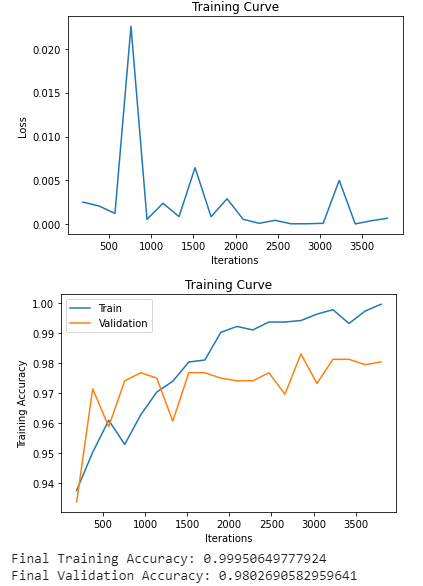

Honestly, I'm satisfied with the results above, but let's play with 2 more hyperparameters.

Training Started...
0 0.9106760980424412 0.9076233183856502
1 0.9434117453528541 0.9434977578475336
2 0.9536107912485606 0.9632286995515695
3 0.9600263201184406 0.9668161434977578
4 0.9634808356637605 0.9668161434977578
5 0.9601908208586939 0.9605381165919282
6 0.9631518341832538 0.979372197309417
7 0.9657838460273072 0.9829596412556054
8 0.9713768711959204 0.9704035874439462
9 0.9715413719361737 0.9730941704035875
10 0.9725283763776937 0.979372197309417
11 0.9766408948840269 0.97847533632287
12 0.9784504030268136 0.9829596412556054
13 0.9769698963645337 0.9847533632286996
14 0.9777924000658003 0.9748878923766816
15 0.9768053956242803 0.9829596412556054
16 0.9820694193123869 0.9811659192825112
17 0.9802599111696003 0.9856502242152466
18 0.9713768711959204 0.9874439461883409
19 0.9828919230136536 0.9811659192825112


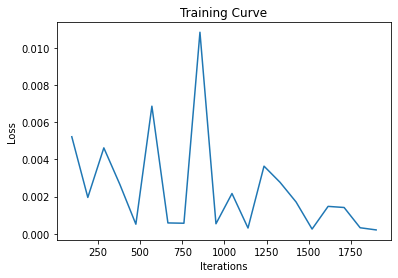

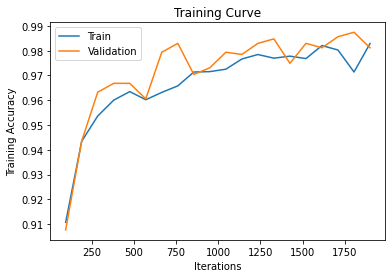

Final Training Accuracy: 0.9828919230136536
Final Validation Accuracy: 0.9811659192825112


([0.9106760980424412,
  0.9434117453528541,
  0.9536107912485606,
  0.9600263201184406,
  0.9634808356637605,
  0.9601908208586939,
  0.9631518341832538,
  0.9657838460273072,
  0.9713768711959204,
  0.9715413719361737,
  0.9725283763776937,
  0.9766408948840269,
  0.9784504030268136,
  0.9769698963645337,
  0.9777924000658003,
  0.9768053956242803,
  0.9820694193123869,
  0.9802599111696003,
  0.9713768711959204,
  0.9828919230136536],
 [0.9076233183856502,
  0.9434977578475336,
  0.9632286995515695,
  0.9668161434977578,
  0.9668161434977578,
  0.9605381165919282,
  0.979372197309417,
  0.9829596412556054,
  0.9704035874439462,
  0.9730941704035875,
  0.979372197309417,
  0.97847533632287,
  0.9829596412556054,
  0.9847533632286996,
  0.9748878923766816,
  0.9829596412556054,
  0.9811659192825112,
  0.9856502242152466,
  0.9874439461883409,
  0.9811659192825112])

In [ ]:
# I will increase the batch size to get rid of some noise.

model_20 = SpamRNN(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
train_rnn_network(model_20, train, valid, batch_size=64, num_epochs=20, learning_rate=1e-3)

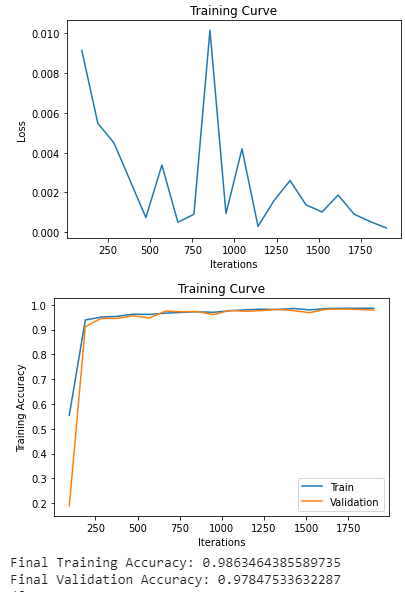

In [ ]:
# I will change hidden layer size to see if more layers will help it detect anything better.

model_9 = SpamRNN(input_size=len(text_field.vocab), hidden_size=30, num_classes=2)
train_rnn_network(model_9, train, valid, batch_size=32, num_epochs=20, learning_rate=1e-3)

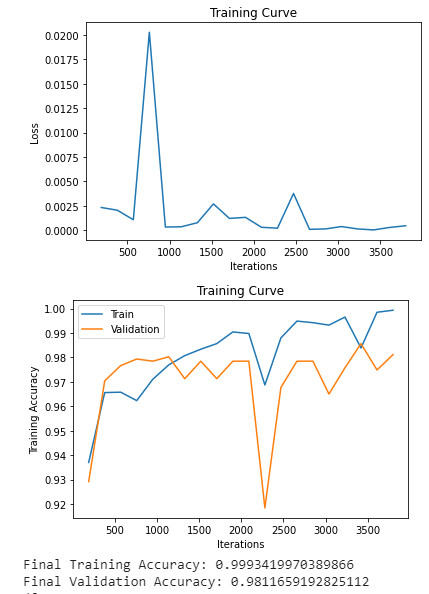

The best validation accuracy was 98.11%, this is from model_9. 

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label != 1],
    valid.fields) # TODO

In [ ]:
spam = get_accuracy(model_20, valid_spam, batch_size = 64)
nospam = get_accuracy(model_20, valid_nospam, batch_size = 64)

## If positive means spam, then the false positive and false negative are:
print("False negative is: {}".format(1 - spam))
print("False positive is: {}".format(1 - nospam))

False negative is: 0.038461538461538436
False positive is: 0.015641293013555768


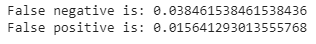

### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In your inbox, you can filter spam messages using built-in algorithms. On my phone, a false positive might mean a message I sent (intended as not spam) is marked as spam... so when I'm texting a friend, the message might never reach them... This might be detrimental if the message is important. 

A false negative means I might be getting spam SMS messages from others, but I they won't be marked as spam due to the algorithm and I would be receiving unwanted messages. 

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
## I use the test_set as the input so although the graphs say it's validation, it's actually the accuracies of the test set rather than the validation set. 

model_test = SpamRNN(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
train_rnn_network(model_test, train, test, batch_size=64, num_epochs=20, learning_rate=1e-3)

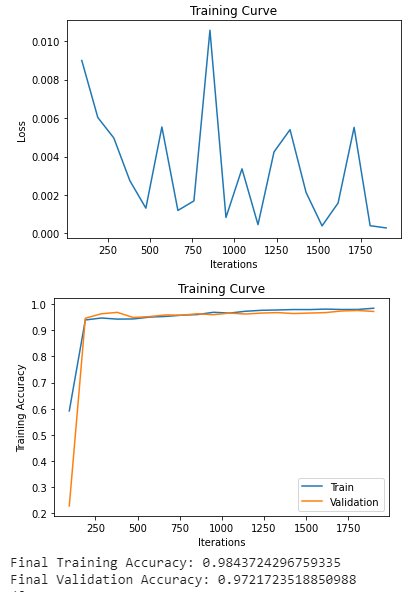

The final test accuracy is 97.22%. 

### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# Create a Dataset of only spam test examples
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam test examples
test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label != 1],
    test.fields) # TODO

In [ ]:
spamt = get_accuracy(model_20, test_spam, batch_size = 64)
nospamt = get_accuracy(model_20, test_nospam, batch_size = 64)

## If positive means spam, then the false positive and false negative are:
print("False negative is: {}".format(1 - spamt))
print("False positive is: {}".format(1 - nospamt))

False negative is: 0.06666666666666665
False positive is: 0.023493360572012234


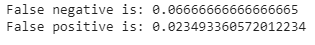

### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"

msglist = []

for item in msg:
  a = text_field.vocab.stoi["{}".format(item)]
  msglist.append(a)

print(msglist)
## Input the tensor into the model to check 
#model_20(msglist)

[18, 6, 17, 13, 9, 7, 3, 2, 11, 3, 6, 8, 7, 9, 7, 22, 2, 9, 10, 2, 10, 4, 4, 4, 2, 17, 4, 4, 11, 46]


In [ ]:
import numpy as np

arr = np.array(msglist)

tens = torch.from_numpy(arr)


tens = tens.unsqueeze(0)

print(tens)

prediction = model_20(tens)

print(prediction)

tensor([[18,  6, 17, 13,  9,  7,  3,  2, 11,  3,  6,  8,  7,  9,  7, 22,  2,  9,
         10,  2, 10,  4,  4,  4,  2, 17,  4,  4, 11, 46]])
tensor([[ 2.2033, -2.2672]], grad_fn=<AddmmBackward>)


In [ ]:
func = nn.Softmax(dim=1)
input = prediction
output = func(input)

print(output)

tensor([[0.9887, 0.0113]], grad_fn=<SoftmaxBackward>)


My model predicts this to NOT be a spam message. It's 98.87% certain it's not spam. 

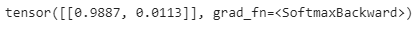

### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

Spam detection is an easy task in my eyes because spam messages usually follow similar formats to draw you in and trick you. They use phrases like "click here" or "You've just won". 

As spam messages typically use certain phrases and words to draw people in, we could build a simple python algorithm that cycles through each SMS message and detect the presence these words and phrases. If one or more words/phrases are present, the SMS will be labelled as spam, otherwise, it'll be labelled as non-spam. To find the accuracy, you could manually go through the messages yourself to label them, then compare the labels with the output of the simple algorithm to get the accuracy of the baseline model. 